# Semantic Image Segmentation

The problem is to identify vegetation patches in satellite images which is a binary semantic segmentation task.



### Mounting Drives containing images and installing required packages

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
!pip install keras==2.3.1
!pip install gast>=0.3.2
!pip install tensorflow==2.1.0
!pip install -U segmentation-models

     |████████████████████████████████| 378kB 5.9MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 421.8MB 26kB/s 
     |████████████████████████████████| 3.9MB 37.3MB/s 
     |████████████████████████████████| 450kB 38.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=097770e0dc1cc5b370d7107df3a545278ce981791288b3c5f84bbdf1fcba0709
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tenso

### Importing Necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2 as cv
import glob
import os
import gc
from tqdm import tqdm, trange
import warnings
warnings.filterwarnings("ignore")

sns.set()
%matplotlib inline

### GPU availability

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU')[0])

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### Extracting vegetation mask

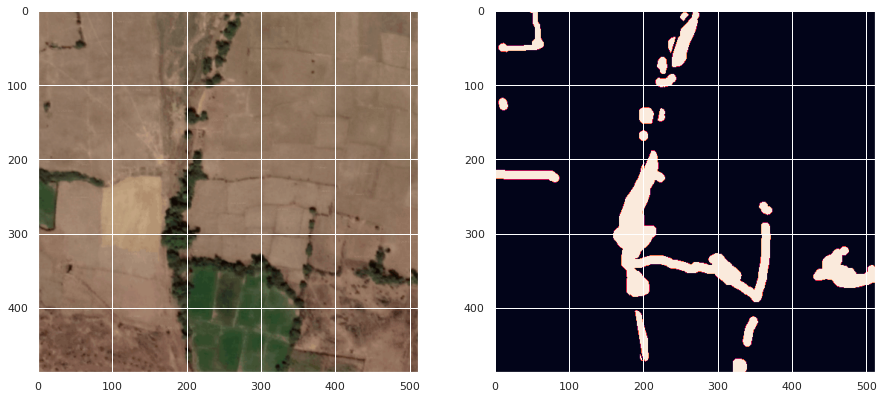

In [ ]:
mask = cv.imread("/content/gdrive/My Drive/SemanticImageSegmentation/train/train/masks/TN_628553_13.48331743_80.02359483_18.png")
mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
mask = np.where((mask == [255, 201, 0]).all(axis=2), 255, 0).astype('uint8')
mask = cv.resize(mask, (512, 487))
thresh, mask = cv.threshold(mask,127,255,cv.THRESH_BINARY)

img = cv.imread("/content/gdrive/My Drive/SemanticImageSegmentation/train/train/satellite/TN_628553_13.48331743_80.02359483_18.png")
img = cv.resize(img, (512, 487))
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(mask)

img = img/255
mask = mask/255

In [ ]:
(img.shape, mask.shape)

((487, 512, 3), (487, 512))

In [3]:
TRAIN_PATH_IMG = "/content/gdrive/My Drive/SemanticImageSegmentation/train/train/satellite/"
TRAIN_PATH_MASKS = "/content/gdrive/My Drive/SemanticImageSegmentation/train/train/masks/"
COLOR_VALUE_RGB = [255, 201, 0]

def create_train(img_path=TRAIN_PATH_IMG, masks_path=TRAIN_PATH_MASKS, color=COLOR_VALUE_RGB):
    n = len(glob.glob1(img_path,"*.png"))
    assert n == len(glob.glob1(masks_path,"*.png")), "Number of images and masks do not match"
    
    X = np.zeros((n*16, 128, 128, 3), dtype=np.uint8)
    y = np.zeros((n*16, 128, 128), dtype=np.uint8)
        
    for i, f in tqdm(enumerate(os.listdir(img_path))):
        
        img = cv.imread(os.path.join(img_path, f))
        img = cv.resize(img, (512, 487))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)   
        
        mask = cv.imread(os.path.join(masks_path, f))
        mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
        mask = np.where((mask == [255, 201, 0]).all(axis=2), 255, 0).astype('uint8')
        mask = cv.resize(mask, (512, 487))
        thresh, mask = cv.threshold(mask,127,255,cv.THRESH_BINARY)

        X[i*16] = img[:128, :128]
        y[i*16] = mask[:128, :128]
        
        X[i*16+1] = img[:128, 128:256]
        y[i*16+1] = mask[:128, 128:256]
        
        X[i*16+2] = img[:128, 256:384]
        y[i*16+2] = mask[:128, 256:384]
        
        X[i*16+3] = img[:128, 384:]
        y[i*16+3] = mask[:128, 384:]
        
        X[i*16+4] = img[128:256, :128]
        y[i*16+4] = mask[128:256, :128]
        
        X[i*16+5] = img[128:256, 128:256]
        y[i*16+5] = mask[128:256, 128:256]
        
        X[i*16+6] = img[128:256, 256:384]
        y[i*16+6] = mask[128:256, 256:384]
        
        X[i*16+7] = img[128:256, 384:]
        y[i*16+7] = mask[128:256, 384:]
        
        X[i*16+8] = img[256:384, :128]
        y[i*16+8] = mask[256:384, :128]
        
        X[i*16+9] = img[256:384, 128:256]
        y[i*16+9] = mask[256:384, 128:256]
        
        X[i*16+10] = img[256:384, 256:384]
        y[i*16+10] = mask[256:384, 256:384]
        
        X[i*16+11] = img[256:384, 384:]
        y[i*16+11] = mask[256:384, 384:]
        
        X[i*16+12] = img[-128:, :128]
        y[i*16+12] = mask[-128:, :128]
        
        X[i*16+13] = img[-128:, 128:256]
        y[i*16+13] = mask[-128:, 128:256]
        
        X[i*16+14] = img[-128:, 256:384]
        y[i*16+14] = mask[-128:, 256:384]
        
        X[i*16+15] = img[-128:, 384:]
        y[i*16+15] = mask[-128:, 384:]

        del img
        del mask
        gc.collect()
    
    return X, y

X_train, y_train = create_train()

441it [04:36,  1.60it/s]


### Some examples after splitting images and resizing

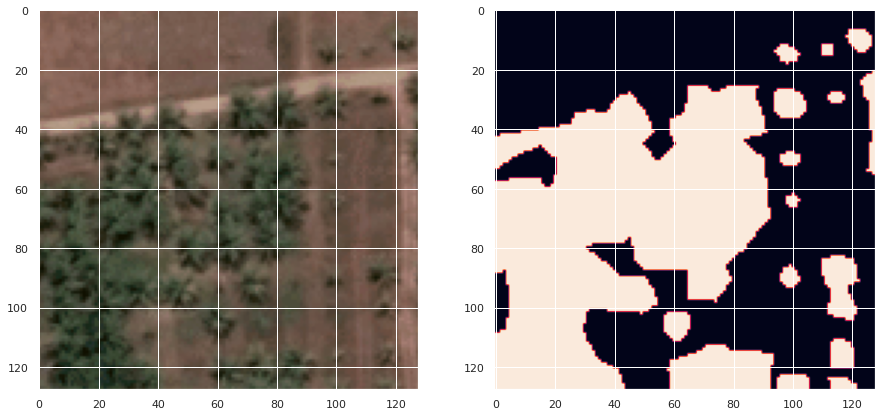

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(X_train[25])
plt.subplot(122)
plt.imshow(y_train[25])

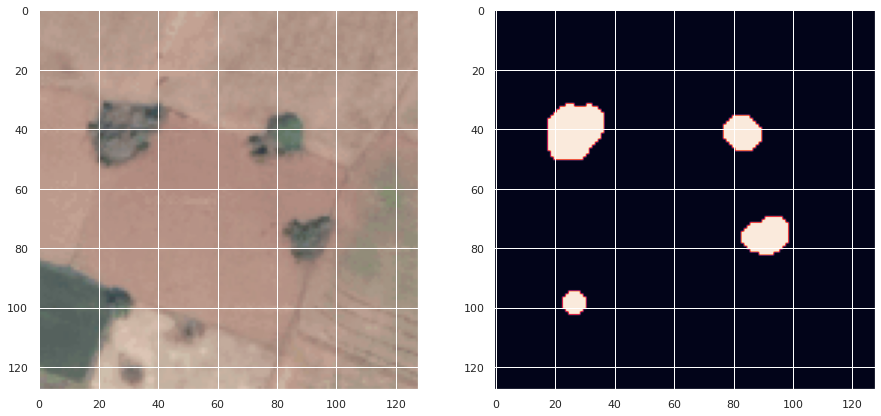

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(X_train[12])
plt.subplot(122)
plt.imshow(y_train[12])

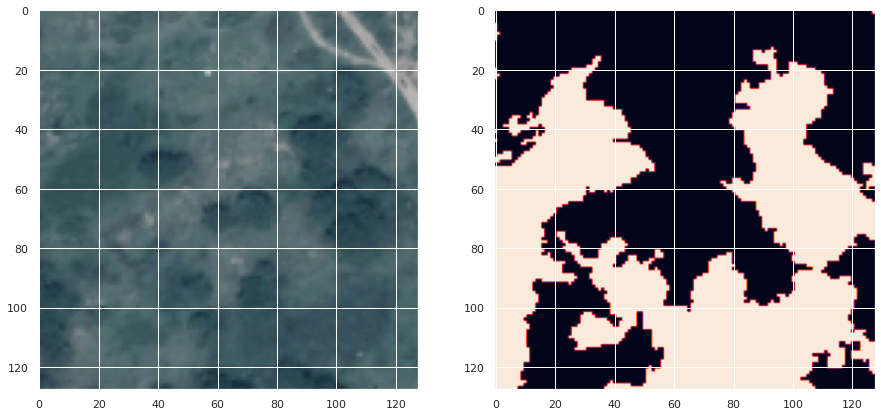

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(X_train[40])
plt.subplot(122)
plt.imshow(y_train[40])

In [8]:
X = X_train/255
y = (y_train/255).astype('int8')

In [9]:
del X_train
del y_train
gc.collect()

44

### Importing libraries for building model

In [4]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.losses import binary_crossentropy
from keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Input, Conv2D, Reshape
from keras.models import Model

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


### Random Seed for reproducibity

In [5]:
RANDOM_SEED = 42

In [6]:
import random

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### Splitting train and validation

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)
BACKBONE = 'resnet101'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [11]:
del X
del y
gc.collect()

281

In [ ]:
from keras.layers import Reshape
import keras.layers as layers

base_model = Unet(
    backbone_name='resnet101', 
    encoder_weights='imagenet', 
    input_shape=(128, 128, 3), 
    decoder_block_type="upsampling", 
    encoder_freeze=False
    )

inp = Input(shape=(128, 128, 3))

out = base_model(inp)

x_out = Reshape((128, 128))(out)

model = Model(inp, x_out, name=base_model.name)

In [15]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

def loss1(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

def loss2(y_true, y_pred):
    return (1 - dice_coefficient(y_true, y_pred))

def loss3(y_true, y_pred):
    return (1 - iou_score(y_true, y_pred))

In [ ]:
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)

In [ ]:
model.compile(optimizer=optimizer, loss=loss1, metrics=[iou_score])

In [ ]:
history = model.fit(X_train, y_train,batch_size=64,epochs=50,validation_data=(X_test, y_test))

Train on 6350 samples, validate on 706 samples
Epoch 1/50
6350/6350 [==============================] - 92s 14ms/step - loss: 0.7484 - iou_score: 0.4926 - val_loss: 3.7512 - val_iou_score: 0.0369
Epoch 2/50
6350/6350 [==============================] - 51s 8ms/step - loss: 0.5049 - iou_score: 0.6119 - val_loss: 5.1697 - val_iou_score: 0.0078
Epoch 3/50
6350/6350 [==============================] - 51s 8ms/step - loss: 0.4313 - iou_score: 0.6566 - val_loss: 6.5704 - val_iou_score: 0.0025
Epoch 4/50
6350/6350 [==============================] - 51s 8ms/step - loss: 0.3895 - iou_score: 0.6853 - val_loss: 7.0329 - val_iou_score: 0.0017
Epoch 5/50
6350/6350 [==============================] - 51s 8ms/step - loss: 0.3683 - iou_score: 0.7006 - val_loss: 7.5918 - val_iou_score: 0.0011
Epoch 6/50
6350/6350 [==============================] - 51s 8ms/step - loss: 0.3298 - iou_score: 0.7248 - val_loss: 7.7414 - val_iou_score: 9.6942e-04
Epoch 7/50
6350/6350 [==============================] - 51s 8ms/st

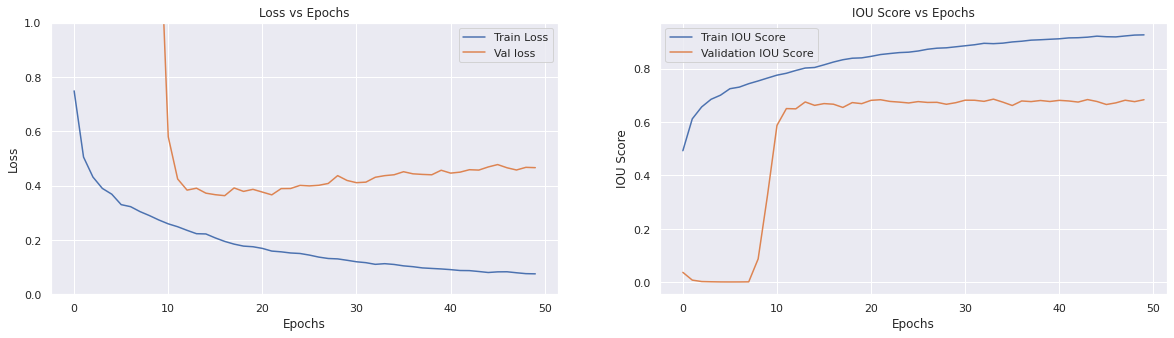

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.subplot(122)
plt.plot(history.history["iou_score"], label="Train IOU Score")
plt.plot(history.history["val_iou_score"], label="Validation IOU Score")
plt.title("IOU Score vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("IOU Score")
plt.legend()

The losses start to diverge after 22 epochs, so we retrain upto 22 epochs

In [ ]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

base_model = Unet(backbone_name='resnet101', encoder_weights='imagenet', input_shape=(128, 128, 3))
inp = Input(shape=(128, 128, 3))
out = base_model(inp)
x_out = Reshape((128, 128))(out)
model = Model(inp, x_out, name=base_model.name)

In [ ]:
model.compile(optimizer=optimizer, loss=loss1, metrics=[iou_score])

In [ ]:
model.fit(X_train,y_train,batch_size=64,epochs=22,validation_data=(X_test, y_test))

Train on 6350 samples, validate on 706 samples
Epoch 1/22
6350/6350 [==============================] - 94s 15ms/step - loss: 0.7454 - iou_score: 0.4957 - val_loss: 16.8990 - val_iou_score: 4.5150e-07
Epoch 2/22
6350/6350 [==============================] - 51s 8ms/step - loss: 0.4878 - iou_score: 0.6216 - val_loss: 6.5702 - val_iou_score: 0.0068
Epoch 3/22
6350/6350 [==============================] - 50s 8ms/step - loss: 0.4335 - iou_score: 0.6572 - val_loss: 7.3569 - val_iou_score: 0.0023
Epoch 4/22
6350/6350 [==============================] - 51s 8ms/step - loss: 0.3873 - iou_score: 0.6852 - val_loss: 6.7989 - val_iou_score: 0.0026
Epoch 5/22
6350/6350 [==============================] - 50s 8ms/step - loss: 0.3631 - iou_score: 0.7024 - val_loss: 7.4252 - val_iou_score: 0.0012
Epoch 6/22
6350/6350 [==============================] - 51s 8ms/step - loss: 0.3277 - iou_score: 0.7264 - val_loss: 5.6567 - val_iou_score: 0.0052
Epoch 7/22
6350/6350 [==============================] - 51s 8ms/s

In [ ]:
y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)

In [ ]:
from sklearn.metrics import jaccard_similarity_score

scores = [jaccard_similarity_score(test, pred) for test, pred in zip(list(y_test), list(y_pred))]
sorted_scores =  np.argsort(scores)

### Visualizing wrong prediction on the validation set

Text(0.5, 1.0, 'Predicted Mask')

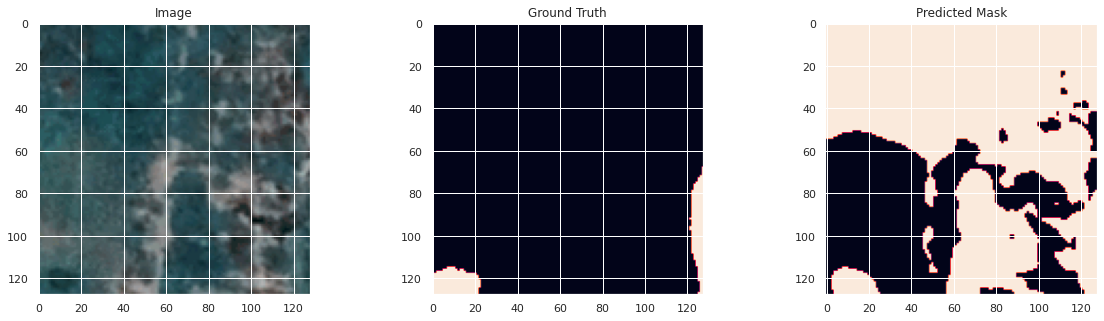

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow((X_test[sorted_scores[0]]*255).astype('uint8'))
plt.title("Image")
plt.subplot(132)
plt.imshow(y_test[sorted_scores[0]]*255)
plt.title("Ground Truth")
plt.subplot(133)
plt.imshow(y_pred[sorted_scores[0]]*255)
plt.title("Predicted Mask")

Text(0.5, 1.0, 'Predicted Mask')

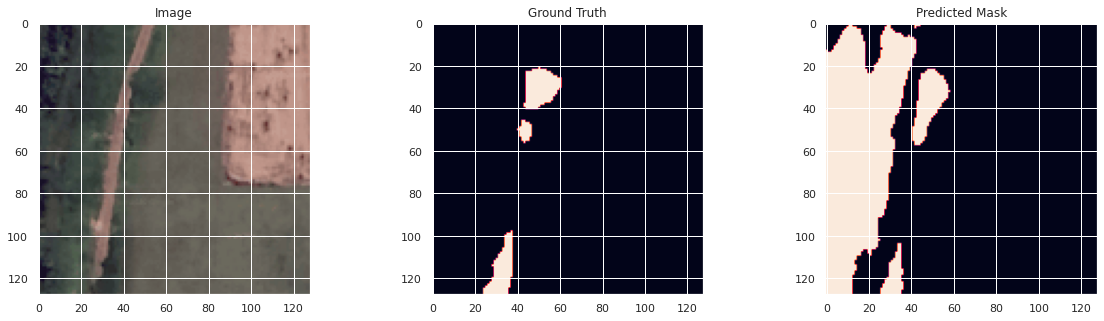

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow((X_test[sorted_scores[1]]*255).astype('uint8'))
plt.title("Image")
plt.subplot(132)
plt.imshow(y_test[sorted_scores[1]]*255)
plt.title("Ground Truth")
plt.subplot(133)
plt.imshow(y_pred[sorted_scores[1]]*255)
plt.title("Predicted Mask")

Text(0.5, 1.0, 'Predicted Mask')

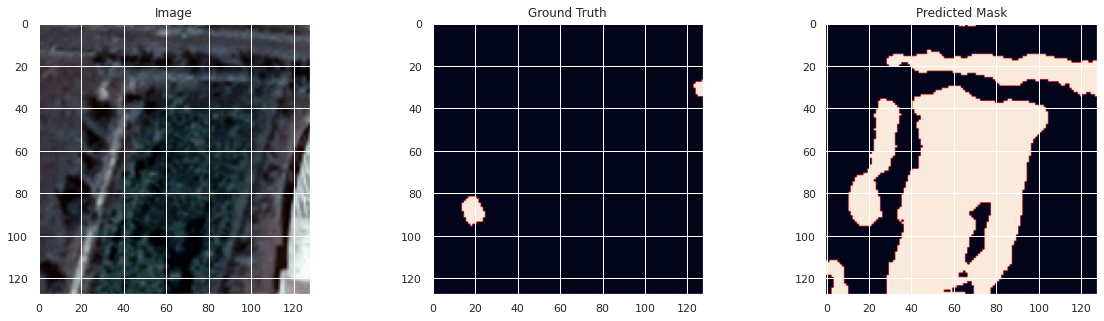

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow((X_test[sorted_scores[2]]*255).astype('uint8'))
plt.title("Image")
plt.subplot(132)
plt.imshow(y_test[sorted_scores[2]]*255)
plt.title("Ground Truth")
plt.subplot(133)
plt.imshow(y_pred[sorted_scores[2]]*255)
plt.title("Predicted Mask")

**Observation**:  We observe that the results are bad mostly because of confusion due to grass that looks almost like vegetation. This also shows that a higher resolution would give better results as the texture of the grass is really important to distinguish it.

### Score Distribution

(array([  3.,   3.,   5.,  20.,  46.,  59.,  98., 149., 141., 182.]),
 array([0.06216432, 0.15594788, 0.24973145, 0.34351502, 0.43729859,
        0.53108216, 0.62486573, 0.71864929, 0.81243286, 0.90621643,
        1.        ]),
 <a list of 10 Patch objects>)

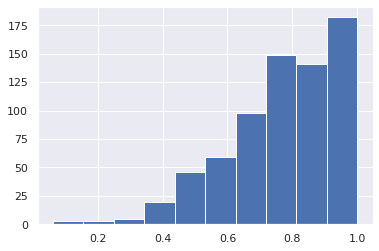

In [ ]:
plt.hist(scores)

The scores have a wide distribution which means the model is failing on some specific types of images. We can see from the bad predictions above that the model fails when there is grass in the image, especially if the grass is dark.

The above model was trained with various hyperparameters and the model shown above is the best one achieved for images of size **128x128**

The hyperparameters:


1.   batch_size (16, 32, 64, 128)
2.   learning_rate (1e-2 to 1e-3)
3.   decoder_block_type ("upsampling" or "transpose")
4.   optimizer (Adam, SGD, Adagrad)
5.   backbone_name ("resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "vgg16")
6.   encoder_freeze (True or False)
7.   loss (loss1 or loss2 or loss3)
      - loss1 = BCE - log(dice)
      - loss2 = 1 - dice
      - loss3 = 1 - iou_score




### Functions for generating masks for test set

In [ ]:
def create_mask(y):
    return np.concatenate((
        np.concatenate((y[0], y[1], y[2], y[3]), axis=1),
        np.concatenate((y[4], y[5], y[6], y[7]), axis=1),
        np.concatenate((y[8], y[9], y[10], y[11]), axis=1),
        np.concatenate((y[12], y[13], y[14], y[15]), axis=1)[-103:,:]
    ),
    axis = 0)
    

In [ ]:
def pred(model, img_path):
    img = cv.imread(img_path)
    img = cv.resize(img, (512, 487))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  

    X = np.zeros((16, 128, 128, 3), dtype=np.uint8)

    X[0] = img[:128, :128]
    X[1] = img[:128, 128:256]
    X[2] = img[:128, 256:384]
    X[3] = img[:128, 384:]
    X[4] = img[128:256, :128]
    X[5] = img[128:256, 128:256]
    X[6] = img[128:256, 256:384]
    X[7] = img[128:256, 384:]
    X[8] = img[256:384, :128]
    X[9] = img[256:384, 128:256]
    X[10] = img[256:384, 256:384]
    X[11] = img[256:384, 384:]
    X[12] = img[-128:, :128]
    X[13] = img[-128:, 128:256]
    X[14] = img[-128:, 256:384]
    X[15] = img[-128:, 384:]

    X = X/255

    y = model.predict(X)

    final_mask = create_mask(y)
    final_mask = (final_mask*255).astype('uint8')
    assert final_mask.shape == (487, 512), "Not proper shape"
    final_mask = cv.resize(final_mask, (2048, 1948))
    thresh, final_mask = cv.threshold(final_mask,127,255,cv.THRESH_BINARY)

    return final_mask

In [ ]:
def run_length_encoder(img):
    r, c = img.shape[:2]
    out = ""

    counting = False
    start_pix = 0
    count = 0
    for i in range(c):
        for j in range(r):
            if not counting:
                if img[j, i] == 255:
                    counting = True
                    start_pix = i*r + j + 1
                    count = 1
            else:
                if img[j, i] == 255:
                    count += 1
                else:
                    out = out + str(start_pix) + " " + str(count) + " "
                    count = 0
                    counting = False
                    start_pix = 0
    
    if counting:
        out = out + str(start_pix) + " " + str(count) + " "
    
    return out.strip()

### Visualizing predictions on test set

Text(0.5, 1.0, 'Mask')

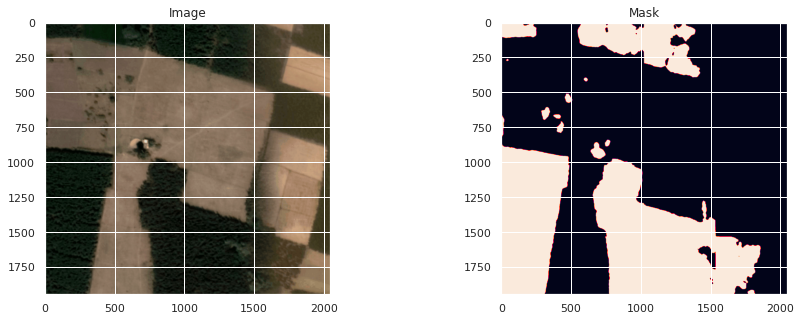

In [ ]:
mask = pred(model, f"/content/gdrive/My Drive/SemanticImageSegmentation/test/test/satellite/TN_632663_12.17698923_79.74434127_18.png")
img = cv.imread("/content/gdrive/My Drive/SemanticImageSegmentation/test/test/satellite/TN_632663_12.17698923_79.74434127_18.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.imshow(img)
plt.title("Image")
plt.subplot(122)
plt.imshow(mask)
plt.title("Mask")

In [ ]:
submission = pd.read_csv("/content/gdrive/My Drive/SemanticImageSegmentation/Sample Submission.csv")
submission.head()

,ImageId,EncodedPixels
0,TN_632663_12.17698923_79.74434127_18.png,1 1
1,TN_632269_12.4309812_79.29519495_18.png,1 1
2,TN_632589_12.22150005_79.86395921_18.png,1 1
3,TN_632406_12.25225177_79.47212711_18.png,1 1
4,TN_632592_12.17579518_79.89499740000002_18.png,1 1


In [ ]:
encoded_pixels = []
for f in tqdm(list(submission["ImageId"])):
  mask = pred(model, f"/content/gdrive/My Drive/SemanticImageSegmentation/test/test/satellite/{f}")
  encoded_pixels.append(run_length_encoder(mask))

100%|██████████| 50/50 [05:37<00:00,  6.75s/it]


In [ ]:
submission["EncodedPixels"] = encoded_pixels
submission.to_csv("submission.csv", index=False)

Other than varying the hyperparameters for the above, the following models were also tried, one with augmentation, one with higher image resolution and one with adding more convolution blocks

The one with higher image resolution showed better performance

The code used for each of these is shown below.

Also, the results obtained from using higher image resolution is also shown

## Using 256x256 images for training

In [ ]:
del X_train
del X_test
del y_train
del y_test
del model
gc.collect()

In [10]:
TRAIN_PATH_IMG = "/content/gdrive/My Drive/SemanticImageSegmentation/train/train/satellite/"
TRAIN_PATH_MASKS = "/content/gdrive/My Drive/SemanticImageSegmentation/train/train/masks/"
COLOR_VALUE_RGB = [255, 201, 0]

def create_train(img_path=TRAIN_PATH_IMG, masks_path=TRAIN_PATH_MASKS, color=COLOR_VALUE_RGB):
    n = len(glob.glob1(img_path,"*.png"))
    assert n == len(glob.glob1(masks_path,"*.png")), "Number of images and masks do not match"
    
    X = np.zeros(((n//2)*16, 256, 256, 3), dtype=np.uint8)
    y = np.zeros(((n//2)*16, 256, 256), dtype=np.uint8)
        
    for i, f in tqdm(enumerate(os.listdir(img_path))):
        
        if i == n//2:
          break

        img = cv.imread(os.path.join(img_path, f))
        img = cv.resize(img, (1024, 974))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)   
        
        mask = cv.imread(os.path.join(masks_path, f))
        mask = cv.cvtColor(mask, cv.COLOR_BGR2RGB)
        mask = np.where((mask == color).all(axis=2), 255, 0).astype('uint8')
        mask = cv.resize(mask, (1024, 974))
        thresh, mask = cv.threshold(mask,127,255,cv.THRESH_BINARY)

        X[i*16] = img[:256, :256]
        y[i*16] = mask[:256, :256]
        
        X[i*16+1] = img[:256, 256:512]
        y[i*16+1] = mask[:256, 256:512]
        
        X[i*16+2] = img[:256, 512:768]
        y[i*16+2] = mask[:256, 512:768]
        
        X[i*16+3] = img[:256, 768:]
        y[i*16+3] = mask[:256, 768:]
        
        X[i*16+4] = img[256:512, :256]
        y[i*16+4] = mask[256:512, :256]
        
        X[i*16+5] = img[256:512, 256:512]
        y[i*16+5] = mask[256:512, 256:512]
        
        X[i*16+6] = img[256:512, 512:768]
        y[i*16+6] = mask[256:512, 512:768]
        
        X[i*16+7] = img[256:512, 768:]
        y[i*16+7] = mask[256:512, 768:]
        
        X[i*16+8] = img[512:768, :256]
        y[i*16+8] = mask[512:768, :256]
        
        X[i*16+9] = img[512:768, 256:512]
        y[i*16+9] = mask[512:768, 256:512]
        
        X[i*16+10] = img[512:768, 512:768]
        y[i*16+10] = mask[512:768, 512:768]
        
        X[i*16+11] = img[512:768, 768:]
        y[i*16+11] = mask[512:768, 768:]
        
        X[i*16+12] = img[-256:, :256]
        y[i*16+12] = mask[-256:, :256]
        
        X[i*16+13] = img[-256:, 256:512]
        y[i*16+13] = mask[-256:, 256:512]
        
        X[i*16+14] = img[-256:, 512:768]
        y[i*16+14] = mask[-256:, 512:768]
        
        X[i*16+15] = img[-256:, 768:]
        y[i*16+15] = mask[-256:, 768:]

        del img
        del mask
        gc.collect()
    
    return X, y

X_train, y_train = create_train()

220it [03:26,  1.05s/it]

Only half the images were taken to not overload RAM

In [11]:
X = X_train/255
y = (y_train/255).astype('int8')

In [12]:
del X_train
del y_train
gc.collect()

380

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
BACKBONE = 'resnet101'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [14]:
del X
del y
gc.collect()

103

In [15]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

base_model = Unet(backbone_name='resnet101', encoder_weights='imagenet', input_shape=(256, 256, 3))
inp = Input(shape=(256, 256, 3))
out = base_model(inp)
x_out = Reshape((256, 256))(out)
model = Model(inp, x_out, name=base_model.name)

171171840/171164896 [==============================] - 2s 0us/step


In [16]:
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=loss1, metrics=[iou_score])

In [17]:
history = model.fit(X_train,y_train,batch_size=32,epochs=40,validation_data=(X_test, y_test))

Train on 2816 samples, validate on 704 samples
Epoch 1/40
2816/2816 [==============================] - 142s 50ms/step - loss: 1.0337 - iou_score: 0.3762 - val_loss: 2.4549 - val_iou_score: 0.0968
Epoch 2/40
2816/2816 [==============================] - 83s 29ms/step - loss: 0.6231 - iou_score: 0.5342 - val_loss: 2.2270 - val_iou_score: 0.1139
Epoch 3/40
2816/2816 [==============================] - 83s 30ms/step - loss: 0.4893 - iou_score: 0.6088 - val_loss: 3.4677 - val_iou_score: 0.0382
Epoch 4/40
2816/2816 [==============================] - 83s 30ms/step - loss: 0.4264 - iou_score: 0.6521 - val_loss: 3.6850 - val_iou_score: 0.0318
Epoch 5/40
2816/2816 [==============================] - 83s 29ms/step - loss: 0.3660 - iou_score: 0.6933 - val_loss: 4.5425 - val_iou_score: 0.0158
Epoch 6/40
2816/2816 [==============================] - 83s 30ms/step - loss: 0.3288 - iou_score: 0.7212 - val_loss: 5.4419 - val_iou_score: 0.0077
Epoch 7/40
2816/2816 [==============================] - 83s 30ms

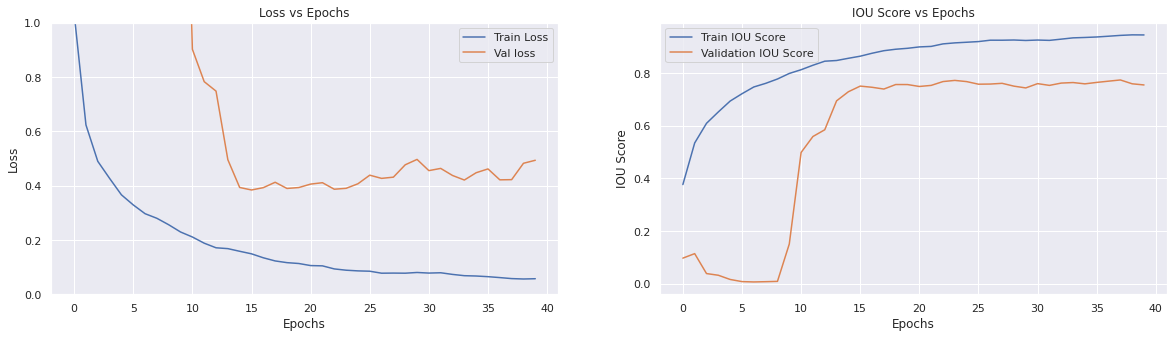

In [18]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.subplot(122)
plt.plot(history.history["iou_score"], label="Train IOU Score")
plt.plot(history.history["val_iou_score"], label="Validation IOU Score")
plt.title("IOU Score vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("IOU Score")
plt.legend()

We train only up to 25 epochs as the model overfits after that

In [22]:
gc.collect()

129

In [20]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

base_model = Unet(backbone_name='resnet101', encoder_weights='imagenet', input_shape=(256, 256, 3))
inp = Input(shape=(256, 256, 3))
out = base_model(inp)
x_out = Reshape((256, 256))(out)
model = Model(inp, x_out, name=base_model.name)

In [23]:
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=loss1, metrics=[iou_score])

In [24]:
history = model.fit(X_train,y_train,batch_size=32,epochs=25,validation_data=(X_test, y_test))

Train on 2816 samples, validate on 704 samples
Epoch 1/25
2816/2816 [==============================] - 134s 47ms/step - loss: 1.0482 - iou_score: 0.3727 - val_loss: 2.8199 - val_iou_score: 0.0713
Epoch 2/25
2816/2816 [==============================] - 83s 30ms/step - loss: 0.6238 - iou_score: 0.5346 - val_loss: 3.1380 - val_iou_score: 0.0531
Epoch 3/25
2816/2816 [==============================] - 83s 30ms/step - loss: 0.4863 - iou_score: 0.6125 - val_loss: 3.3258 - val_iou_score: 0.0426
Epoch 4/25
2816/2816 [==============================] - 83s 30ms/step - loss: 0.4368 - iou_score: 0.6488 - val_loss: 3.7340 - val_iou_score: 0.0306
Epoch 5/25
2816/2816 [==============================] - 83s 30ms/step - loss: 0.3628 - iou_score: 0.6974 - val_loss: 4.5903 - val_iou_score: 0.0152
Epoch 6/25
2816/2816 [==============================] - 83s 30ms/step - loss: 0.3215 - iou_score: 0.7282 - val_loss: 5.0867 - val_iou_score: 0.0102
Epoch 7/25
2816/2816 [==============================] - 83s 30ms

### Visualizing faulty examples

In [30]:
from sklearn.metrics import jaccard_similarity_score

y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)
scores = [jaccard_similarity_score(test, pred) for test, pred in zip(list(y_test), list(y_pred))]
sorted_scores =  np.argsort(scores)

Text(0.5, 1.0, 'Predicted Mask')

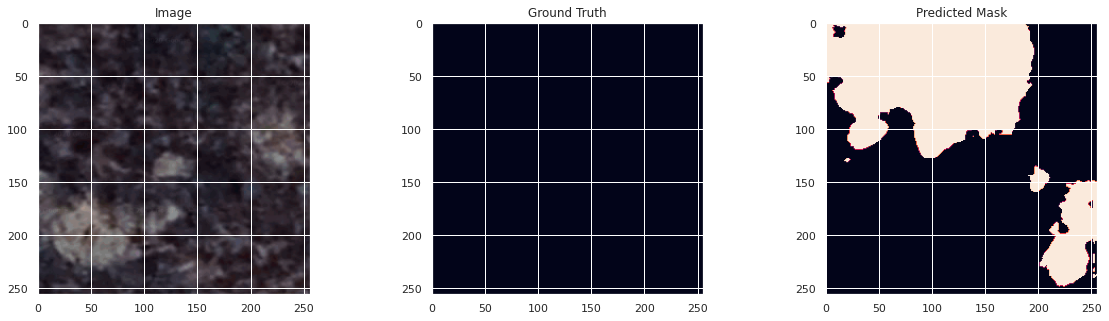

In [32]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow((X_test[sorted_scores[0]]*255).astype('uint8'))
plt.title("Image")
plt.subplot(132)
plt.imshow(y_test[sorted_scores[0]]*255)
plt.title("Ground Truth")
plt.subplot(133)
plt.imshow(y_pred[sorted_scores[0]]*255)
plt.title("Predicted Mask")

Text(0.5, 1.0, 'Predicted Mask')

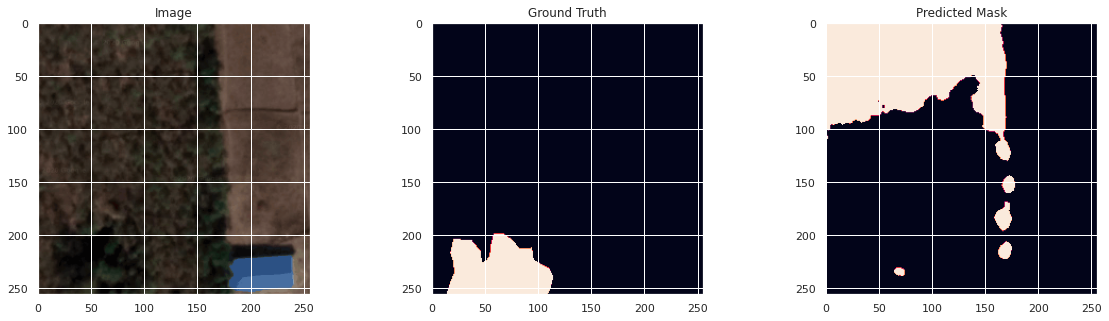

In [34]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow((X_test[sorted_scores[1]]*255).astype('uint8'))
plt.title("Image")
plt.subplot(132)
plt.imshow(y_test[sorted_scores[1]]*255)
plt.title("Ground Truth")
plt.subplot(133)
plt.imshow(y_pred[sorted_scores[1]]*255)
plt.title("Predicted Mask")

Text(0.5, 1.0, 'Predicted Mask')

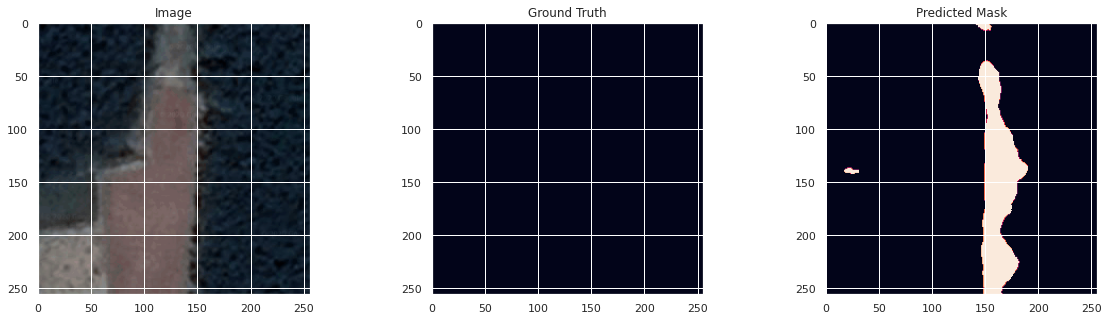

In [35]:
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.imshow((X_test[sorted_scores[2]]*255).astype('uint8'))
plt.title("Image")
plt.subplot(132)
plt.imshow(y_test[sorted_scores[2]]*255)
plt.title("Ground Truth")
plt.subplot(133)
plt.imshow(y_pred[sorted_scores[2]]*255)
plt.title("Predicted Mask")

## Model training with augmentation

In [12]:
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="reflect"
)

In [16]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

base_model = Unet(backbone_name='resnet101', encoder_weights='imagenet', input_shape=(128, 128, 3))
inp = Input(shape=(128, 128, 3))
out = base_model(inp)
x_out = Reshape((128, 128))(out)
model = Model(inp, x_out, name=base_model.name)

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=loss1, metrics=[iou_score])

In [17]:
history = model.fit(x = aug.flow(X_train,y_train,batch_size=32),epochs=30,validation_data=(X_test, y_test), steps_per_epoch=len(X_train)//32)

Epoch 1/30
198/198 [==============================] - 138s 695ms/step - loss: 1.1728 - iou_score: 0.3371 - val_loss: 3.4244 - val_iou_score: 0.0359
Epoch 2/30
198/198 [==============================] - 87s 441ms/step - loss: 0.9855 - iou_score: 0.3973 - val_loss: 6.4091 - val_iou_score: 0.0034
Epoch 3/30
198/198 [==============================] - 88s 445ms/step - loss: 0.9599 - iou_score: 0.4085 - val_loss: 5.8831 - val_iou_score: 0.0046
Epoch 4/30
198/198 [==============================] - 88s 443ms/step - loss: 0.9232 - iou_score: 0.4237 - val_loss: 5.9493 - val_iou_score: 0.0070
Epoch 5/30
198/198 [==============================] - 88s 445ms/step - loss: 0.9129 - iou_score: 0.4271 - val_loss: 1.5182 - val_iou_score: 0.2757
Epoch 6/30
198/198 [==============================] - 89s 448ms/step - loss: 0.8889 - iou_score: 0.4362 - val_loss: 0.8471 - val_iou_score: 0.4190
Epoch 7/30
198/198 [==============================] - 88s 443ms/step - loss: 0.8928 - iou_score: 0.4352 - val_loss: 0

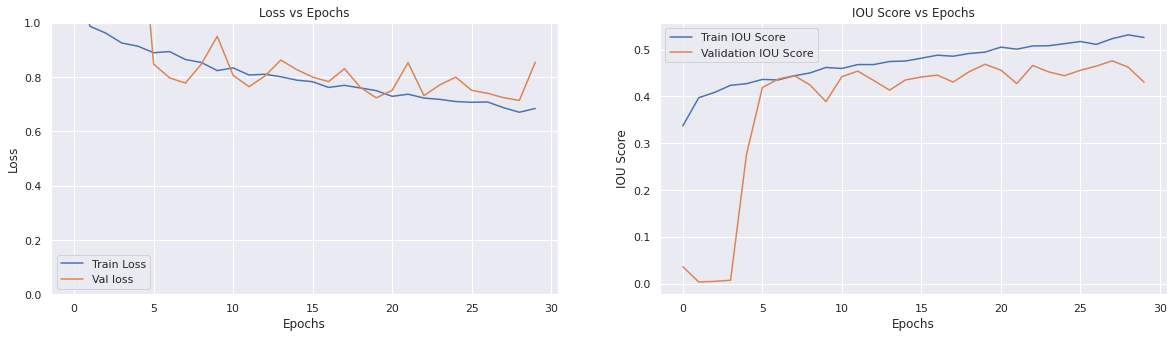

In [18]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.subplot(122)
plt.plot(history.history["iou_score"], label="Train IOU Score")
plt.plot(history.history["val_iou_score"], label="Validation IOU Score")
plt.title("IOU Score vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("IOU Score")
plt.legend()

As we can see that the Validation loss does not decrease after some point, so we don't go further with this model

## Adding more convolution blocks



In [19]:
gc.collect()

344

In [25]:
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, Activation

base_model = Unet(backbone_name='resnet101', encoder_weights='imagenet', input_shape=(128, 128, 3), decoder_block_type='transpose', activation="linear")

inp = Input(shape=(128, 128, 3))

out = base_model(inp)

out = Conv2D(5, 3, padding="same")(out)
out = LeakyReLU(0.1)(out)
out = BatchNormalization()(out)

out = Conv2D(10, 3, padding="same")(out)
out = LeakyReLU(0.1)(out)
out = BatchNormalization()(out)

out = Conv2D(50, 3, padding="same")(out)
out = LeakyReLU(0.1)(out)
out = BatchNormalization()(out)

out = Conv2D(10, 3, padding="same")(out)
out = LeakyReLU(0.1)(out)
out = BatchNormalization()(out)

out = Conv2D(10, 3, padding="same")(out)
out = LeakyReLU(0.1)(out)
out = BatchNormalization()(out)

out = Conv2D(5, 3, padding="same")(out)
out = LeakyReLU(0.1)(out)
out = BatchNormalization()(out)

out = Conv2D(5, 3, padding="same")(out)
out = LeakyReLU(0.1)(out)
out = BatchNormalization()(out)

out = Conv2D(5, 3, padding="same")(out)
out = LeakyReLU(0.1)(out)
out = BatchNormalization()(out)

out = Conv2D(5, 3, padding="same")(out)
out = LeakyReLU(0.1)(out)
out = BatchNormalization()(out)

out = Conv2D(1, 3, padding="same")(out)
out = Activation("sigmoid")(out)

x_out = Reshape((128, 128))(out)

model = Model(inp, x_out, name=base_model.name)

In [27]:
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss=loss1, metrics=[iou_score])

In [28]:
history = model.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test, y_test))

Train on 6350 samples, validate on 706 samples
Epoch 1/30
6350/6350 [==============================] - 154s 24ms/step - loss: 1.1902 - iou_score: 0.3557 - val_loss: 2.0338 - val_iou_score: 0.1200
Epoch 2/30
6350/6350 [==============================] - 94s 15ms/step - loss: 0.7768 - iou_score: 0.4957 - val_loss: 2.5193 - val_iou_score: 0.0732
Epoch 3/30
6350/6350 [==============================] - 94s 15ms/step - loss: 0.6068 - iou_score: 0.5729 - val_loss: 2.9035 - val_iou_score: 0.0525
Epoch 4/30
6350/6350 [==============================] - 94s 15ms/step - loss: 0.5076 - iou_score: 0.6234 - val_loss: 3.3913 - val_iou_score: 0.0347
Epoch 5/30
6350/6350 [==============================] - 94s 15ms/step - loss: 0.4440 - iou_score: 0.6606 - val_loss: 1.1937 - val_iou_score: 0.3162
Epoch 6/30
6350/6350 [==============================] - 93s 15ms/step - loss: 0.3809 - iou_score: 0.6952 - val_loss: 0.5582 - val_iou_score: 0.5753
Epoch 7/30
6350/6350 [==============================] - 93s 15ms

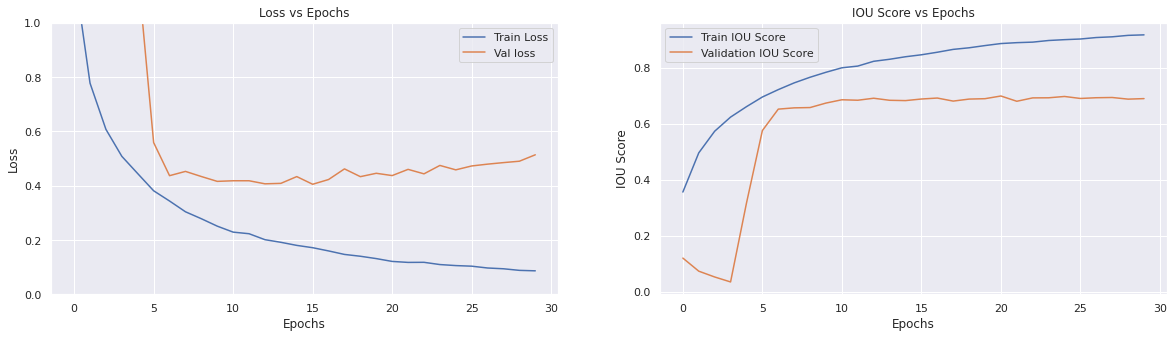

In [29]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0, 1])
plt.legend()
plt.subplot(122)
plt.plot(history.history["iou_score"], label="Train IOU Score")
plt.plot(history.history["val_iou_score"], label="Validation IOU Score")
plt.title("IOU Score vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("IOU Score")
plt.legend()

The Validation score does not increase much and the losses diverge too early which implies overfitting